# Homework 2.2: The Quest For A Better Network

In this assignment you will build a monster network to solve CIFAR10 image classification.

This notebook is intended as a sequel to seminar 3, please give it a try if you haven't done so yet.

(please read it at least diagonally)

* The ultimate quest is to create a network that has as high __accuracy__ as you can push it.
* There is a __mini-report__ at the end that you will have to fill in. We recommend reading it first and filling it while you iterate.
 
## Grading
* starting at zero points
* +20% for describing your iteration path in a report below.
* +20% for building a network that gets above 20% accuracy
* +10% for beating each of these milestones on __TEST__ dataset:
    * 50% (50% points)
    * 60% (60% points)
    * 65% (70% points)
    * 70% (80% points)
    * 75% (90% points)
    * 80% (full points)
    
## Restrictions
* Please do NOT use pre-trained networks for this assignment until you reach 80%.
 * In other words, base milestones must be beaten without pre-trained nets (and such net must be present in the e-mail). After that, you can use whatever you want.
* you __can__ use validation data for training, but you __can't'__ do anything with test data apart from running the evaluation procedure.

## Tips on what can be done:


 * __Network size__
   * MOAR neurons, 
   * MOAR layers, ([torch.nn docs](http://pytorch.org/docs/master/nn.html))

   * Nonlinearities in the hidden layers
     * tanh, relu, leaky relu, etc
   * Larger networks may take more epochs to train, so don't discard your net just because it could didn't beat the baseline in 5 epochs.

   * Ph'nglui mglw'nafh Cthulhu R'lyeh wgah'nagl fhtagn!


### The main rule of prototyping: one change at a time
   * By now you probably have several ideas on what to change. By all means, try them out! But there's a catch: __never test several new things at once__.


### Optimization
   * Training for 100 epochs regardless of anything is probably a bad idea.
   * Some networks converge over 5 epochs, others - over 500.
   * Way to go: stop when validation score is 10 iterations past maximum
   * You should certainly use adaptive optimizers
     * rmsprop, nesterov_momentum, adam, adagrad and so on.
     * Converge faster and sometimes reach better optima
     * It might make sense to tweak learning rate/momentum, other learning parameters, batch size and number of epochs
   * __BatchNormalization__ (nn.BatchNorm2d) for the win!
     * Sometimes more batch normalization is better.
   * __Regularize__ to prevent overfitting
     * Add some L2 weight norm to the loss function, theano will do the rest
       * Can be done manually or like [this](https://discuss.pytorch.org/t/simple-l2-regularization/139/2).
     * Dropout (`nn.Dropout`) - to prevent overfitting
       * Don't overdo it. Check if it actually makes your network better
   
### Convolution architectures
   * This task __can__ be solved by a sequence of convolutions and poolings with batch_norm and ReLU seasoning, but you shouldn't necessarily stop there.
   * [Inception family](https://hacktilldawn.com/2016/09/25/inception-modules-explained-and-implemented/), [ResNet family](https://towardsdatascience.com/an-overview-of-resnet-and-its-variants-5281e2f56035?gi=9018057983ca), [Densely-connected convolutions (exotic)](https://arxiv.org/abs/1608.06993), [Capsule networks (exotic)](https://arxiv.org/abs/1710.09829)
   * Please do try a few simple architectures before you go for resnet-152.
   * Warning! Training convolutional networks can take long without GPU. That's okay.
     * If you are CPU-only, we still recomment that you try a simple convolutional architecture
     * a perfect option is if you can set it up to run at nighttime and check it up at the morning.
     * Make reasonable layer size estimates. A 128-neuron first convolution is likely an overkill.
     * __To reduce computation__ time by a factor in exchange for some accuracy drop, try using __stride__ parameter. A stride=2 convolution should take roughly 1/4 of the default (stride=1) one.
 
   
### Data augmemntation
   * getting 5x as large dataset for free is a great 
     * Zoom-in+slice = move
     * Rotate+zoom(to remove black stripes)
     * Add Noize (gaussian or bernoulli)
   * Simple way to do that (if you have PIL/Image): 
     * ```from scipy.misc import imrotate,imresize```
     * and a few slicing
     * Other cool libraries: cv2, skimake, PIL/Pillow
   * A more advanced way is to use torchvision transforms:
    ```
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    trainset = torchvision.datasets.CIFAR10(root=path_to_cifar_like_in_seminar, train=True, download=True, transform=transform_train)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

    ```
   * Or use this tool from Keras (requires theano/tensorflow): [tutorial](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), [docs](https://keras.io/preprocessing/image/)
   * Stay realistic. There's usually no point in flipping dogs upside down as that is not the way you usually see them.
   
```

```

```

```

```

```

```

```


   
There is a template for your solution below that you can opt to use or throw away and write it your way.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from IPython import display
%matplotlib inline

In [2]:
from cifar import load_cifar10
X_train,y_train,X_val,y_val,X_test,y_test = load_cifar10("cifar_data")
class_names = np.array(['airplane','automobile ','bird ','cat ','deer ','dog ','frog ','horse ','ship ','truck'])

print(X_train.shape,y_train.shape)

(40000, 3, 32, 32) (40000,)


In [3]:
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [4]:
def compute_accuracy(logits, y_batch):
    return accuracy_score(np.argmax(logits.data.cpu().numpy(), axis=1),
                          y_batch.data.cpu().numpy())

In [19]:
def compute_loss_and_accuracy(model, X_batch, y_batch):
    X_batch = Variable(torch.FloatTensor(X_batch)).cuda()
    y_batch = Variable(torch.LongTensor(y_batch)).cuda()
    logits = model(X_batch)
    return F.cross_entropy(logits, y_batch).mean(), compute_accuracy(logits, y_batch)

__ Training __

In [6]:
def iterate_minibatches(X, y, batchsize):
    indices = np.random.permutation(np.arange(len(X)))
    for start in range(0, len(indices), batchsize):
        ix = indices[start: start + batchsize]
        yield X[ix], y[ix]

In [7]:
def update_graph(all_metrics, subplots_layout=(1, 2), figsize=(20, 10), log_scale=False,
                additional_info_fn=None):
    display.clear_output(wait=True)
    fig, axes = plt.subplots(*subplots_layout, figsize=figsize)
    fig.subplots_adjust(hspace=100)
    if log_scale:
        plt.yscale('log')
    width = axes.shape[0]
    height = 1
    if len(axes.shape) > 1:
        height = axes.shape[1]
    for idx, title in enumerate(all_metrics):
        i = idx // width
        j = idx % width
        for label in all_metrics[title]:
            metric_values = all_metrics[title][label]
            if len(axes.shape) > 1:
                ax = axes[i, j]
            else:
                ax = axes[j]
            ax.set(title=title, ylabel=title.lower(), xlabel="#iteration")
            ax.plot(metric_values, label=label)
            ax.legend()
    plt.show()
    if additional_info_fn is not None:
        additional_info_fn()

In [8]:
def print_epoch_results(epoch, num_epochs, epoch_time, batch_size, all_metrics):
    print("Epoch {} of {} time: {:.3f}s".format(
           epoch + 1, num_epochs, epoch_time))
    print("  training loss (in-iteration): \t{:.6f}".format(
        np.mean(all_metrics["Loss"]["train"][-len(X_train) // batch_size :])))
    print("  validation loss (in-iteration): \t{:.6f}".format(
        np.mean(all_metrics["Loss"]["valid"][-len(X_val) // batch_size :])))
    print("  train accuracy: \t\t\t{:.2f} %".format(
        np.mean(all_metrics["Accuracy"]["train"][-len(X_train) // batch_size :]) * 100))
    print("  validation accuracy: \t\t\t{:.2f} %".format(
        np.mean(all_metrics["Accuracy"]["valid"][-len(X_val) // batch_size :]) * 100))

In [9]:
import time

def train(model, num_epochs, batch_size, optimizer_type, optimizer_config={}):
    train_loss = []
    val_accuracy = []
    all_metrics = {"Loss": {"train": [], "valid": []},
                   "Accuracy": {"train": [], "valid": []}}
    optimizer = optimizer_type(model.parameters(), **optimizer_config)
    for epoch in range(num_epochs):
        # In each epoch, we do a full pass over the training data:
        start_time = time.time()
        model.train(True) # enable dropout / batch_norm training behavior
        for idx, (X_batch, y_batch) in enumerate(iterate_minibatches(X_train, y_train, batch_size)):
            # train on batch
            loss, accuracy = compute_loss_and_accuracy(model, X_batch, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            all_metrics["Loss"]["train"].append(loss.data.cpu().numpy()[0])
            all_metrics["Accuracy"]["train"].append(accuracy)
            if idx % 10 == 0:
                update_graph(all_metrics, 
                             additional_info_fn=
                             lambda: print_epoch_results(epoch, num_epochs,
                                                         time.time() - start_time,
                                                         batch_size, all_metrics))
        # And a full pass over the validation data:
        model.train(False) # disable dropout / use averages for batch_norm
        for X_batch, y_batch in iterate_minibatches(X_val, y_val, batch_size):
            loss, accuracy = compute_loss_and_accuracy(model, X_batch, y_batch)
            all_metrics["Loss"]["valid"].append(loss.data.cpu().numpy()[0])
            all_metrics["Accuracy"]["valid"].append(accuracy)
            update_graph(all_metrics, additional_info_fn=
                         lambda: print_epoch_results(epoch, num_epochs,
                                                     time.time() - start_time,
                                                     batch_size, all_metrics))
        
        

In [10]:
def evaluate(model):
    model.train(False) # disable dropout / use averages for batch_norm
    test_batch_acc = []
    for X_batch, y_batch in iterate_minibatches(X_test, y_test, 500):
        logits = model(Variable(torch.FloatTensor(X_batch)).cuda())
        y_pred = logits.max(1)[1].data.cpu().numpy()
        test_batch_acc.append(np.mean(y_batch == y_pred))

    test_accuracy = np.mean(test_batch_acc)

    print("Final results:")
    print("  test accuracy:\t\t{:.2f} %".format(
        test_accuracy * 100))

    if test_accuracy * 100 > 95:
        print("Double-check, than consider applying for NIPS'17. SRSly.")
    elif test_accuracy * 100 > 90:
        print("U'r freakin' amazin'!")
    elif test_accuracy * 100 > 80:
        print("Achievement unlocked: 110lvl Warlock!")
    elif test_accuracy * 100 > 70:
        print("Achievement unlocked: 80lvl Warlock!")
    elif test_accuracy * 100 > 60:
        print("Achievement unlocked: 70lvl Warlock!")
    elif test_accuracy * 100 > 50:
        print("Achievement unlocked: 60lvl Warlock!")
    else:
        print("We need more magic! Follow instructons below")

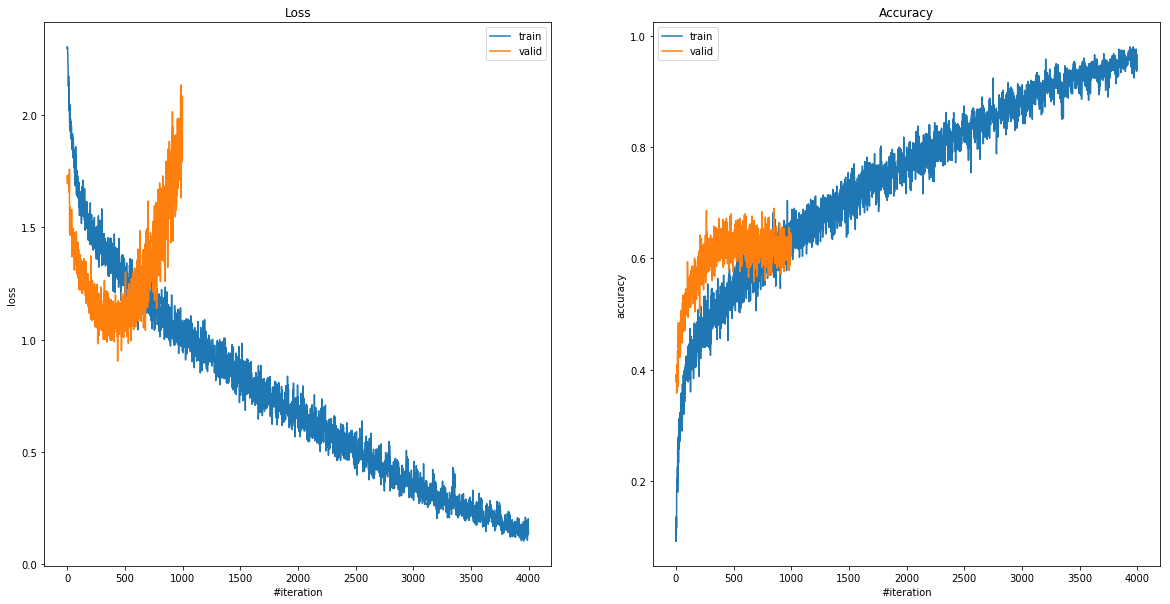

Epoch 50 of 50 time: 7.749s
  training loss (in-iteration): 	0.144548
  validation loss (in-iteration): 	1.922311
  train accuracy: 			96.10 %
  validation accuracy: 			61.38 %
Final results:
  test accuracy:		60.88 %
Achievement unlocked: 70lvl Warlock!


In [32]:
model = nn.Sequential(nn.Conv2d(3, 64, (7, 7), stride=3),
                      nn.ReLU(),
                      nn.Conv2d(64, 128, (5, 5), stride=2),
                      nn.ReLU(),
                      nn.Conv2d(128, 128, (3, 3), stride=2),
                      nn.ReLU(),
                      Flatten(),
                      nn.Linear(128, 10)).cuda()
train(model, num_epochs=50, batch_size=500, optimizer_type=torch.optim.Adam)
evaluate(model)

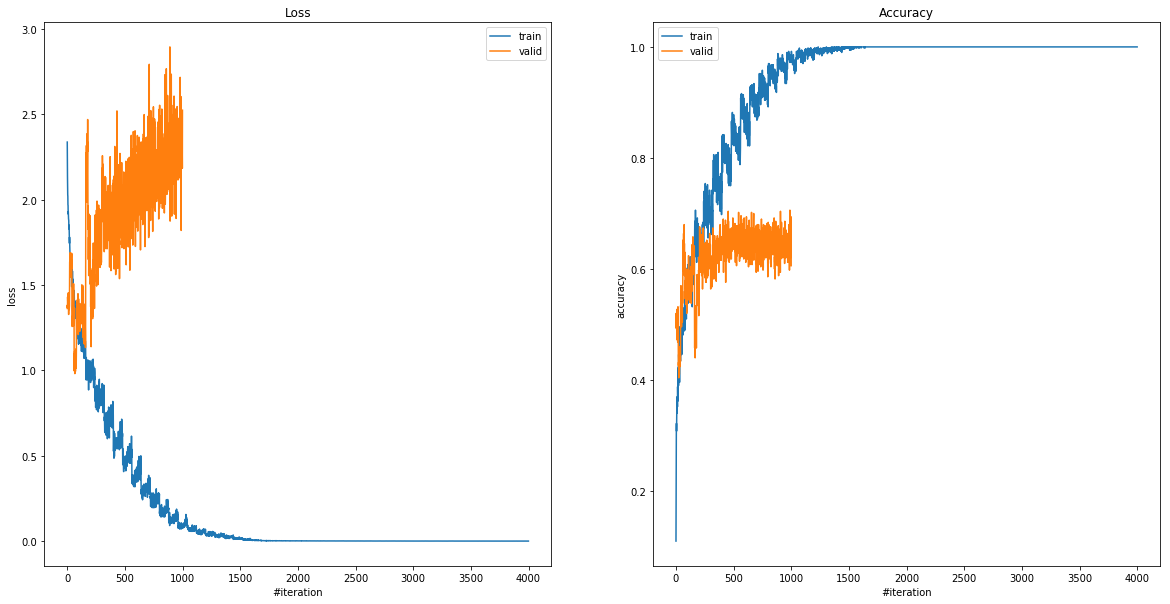

Epoch 50 of 50 time: 7.477s
  training loss (in-iteration): 	0.000258
  validation loss (in-iteration): 	2.345804
  train accuracy: 			100.00 %
  validation accuracy: 			64.55 %
Final results:
  test accuracy:		64.52 %
Achievement unlocked: 70lvl Warlock!


In [34]:
model = nn.Sequential(nn.Conv2d(3, 64, (7, 7), stride=3),
                      nn.BatchNorm2d(64),
                      nn.ReLU(),
                      nn.Conv2d(64, 128, (5, 5), stride=2),
                      nn.BatchNorm2d(128),
                      nn.ReLU(),
                      nn.Conv2d(128, 128, (3, 3), stride=2),
                      nn.BatchNorm2d(128),
                      nn.ReLU(),
                      Flatten(),
                      nn.Linear(128, 10)).cuda()
train(model, num_epochs=50, batch_size=500, optimizer_type=torch.optim.Adam)
evaluate(model)

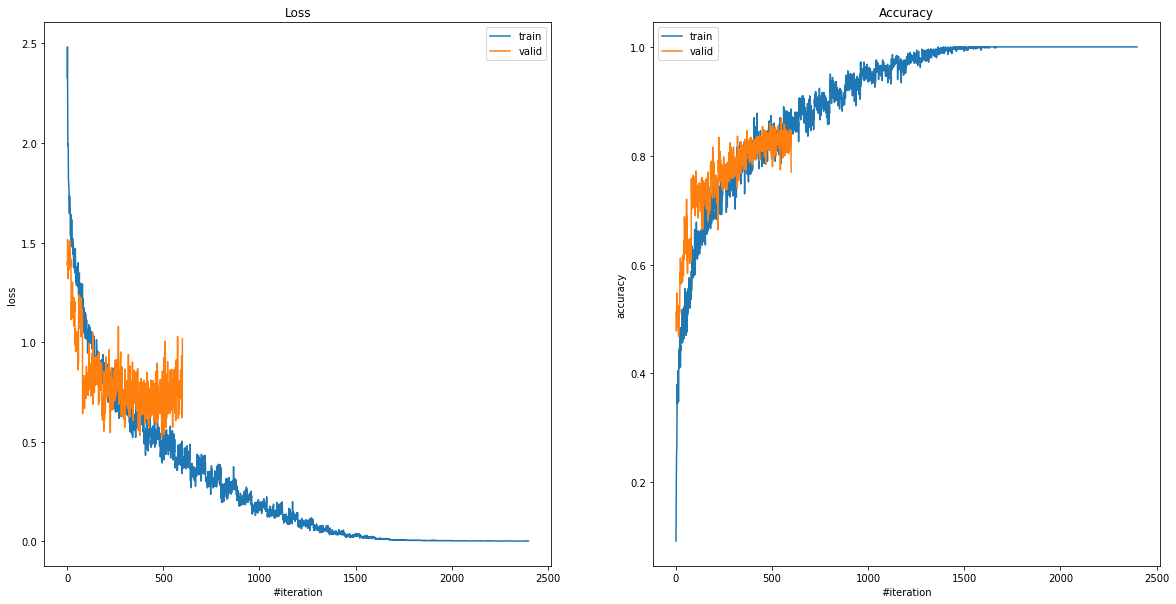

Epoch 30 of 30 time: 17.931s
  training loss (in-iteration): 	0.001970
  validation loss (in-iteration): 	0.774482
  train accuracy: 			100.00 %
  validation accuracy: 			82.29 %
Final results:
  test accuracy:		81.77 %
Achievement unlocked: 110lvl Warlock!


In [33]:
model = nn.Sequential(nn.Conv2d(3, 64, (7, 7), padding=(3, 3)),
                      nn.BatchNorm2d(64),
                      nn.ReLU(),
                      nn.Conv2d(64, 128, (5, 5), padding=(2, 2)),
                      nn.BatchNorm2d(128),
                      nn.ReLU(),
                      nn.MaxPool2d((2, 2), stride=2),
                      nn.Conv2d(128, 128, (3, 3)),
                      nn.BatchNorm2d(128),
                      nn.ReLU(),
                      nn.Conv2d(128, 128, (3, 3)),
                      nn.BatchNorm2d(128),
                      nn.ReLU(),
                      nn.MaxPool2d((2, 2), stride=2),
                      Flatten(),
                      nn.Linear(4608, 10)).cuda()
train(model, num_epochs=30, batch_size=500, optimizer_type=torch.optim.Adam)
evaluate(model)

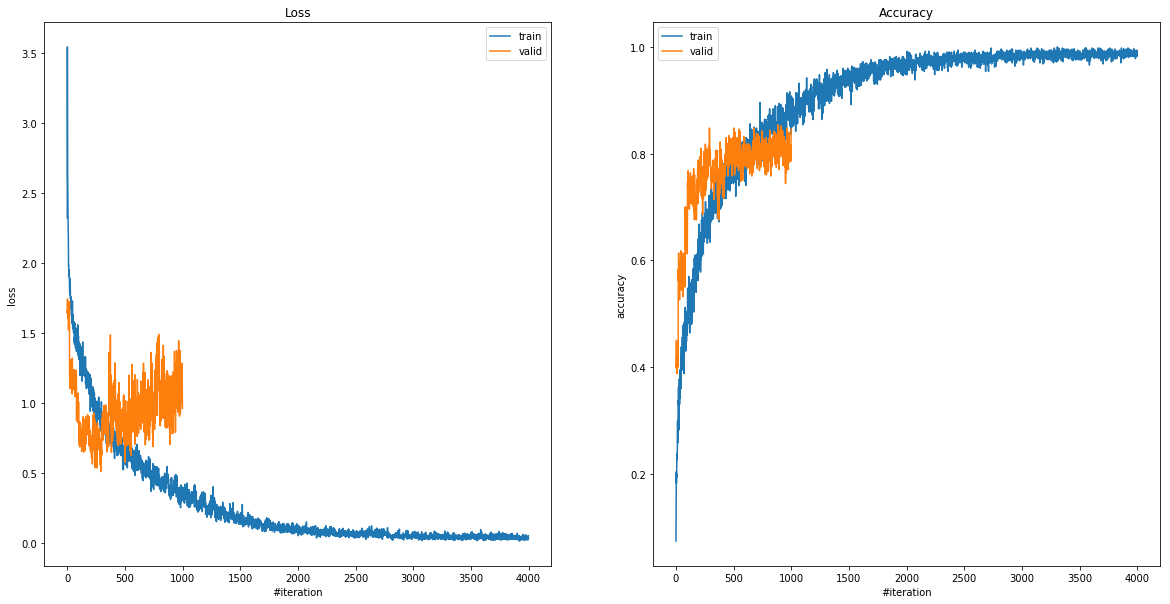

Epoch 50 of 50 time: 19.255s
  training loss (in-iteration): 	0.033556
  validation loss (in-iteration): 	1.139229
  train accuracy: 			98.92 %
  validation accuracy: 			80.71 %
Final results:
  test accuracy:		79.75 %
Achievement unlocked: 80lvl Warlock!


In [12]:
model = nn.Sequential(nn.Conv2d(3, 64, (7, 7), padding=(3, 3)),
                      nn.BatchNorm2d(64),
                      nn.ReLU(),
                      nn.Conv2d(64, 128, (5, 5), padding=(2, 2)),
                      nn.BatchNorm2d(128),
                      nn.ReLU(),
                      nn.MaxPool2d((2, 2), stride=2),
                      nn.Conv2d(128, 128, (3, 3)),
                      nn.BatchNorm2d(128),
                      nn.ReLU(),
                      nn.Conv2d(128, 128, (3, 3)),
                      nn.BatchNorm2d(128),
                      nn.ReLU(),
                      nn.MaxPool2d((2, 2), stride=2),
                      Flatten(),
                      nn.Linear(4608, 1000).cuda(),
                      nn.ReLU(),
                      nn.Dropout(),
                      nn.Linear(1000, 10)).cuda()
train(model, num_epochs=50, batch_size=500, optimizer_type=torch.optim.Adam)
evaluate(model)

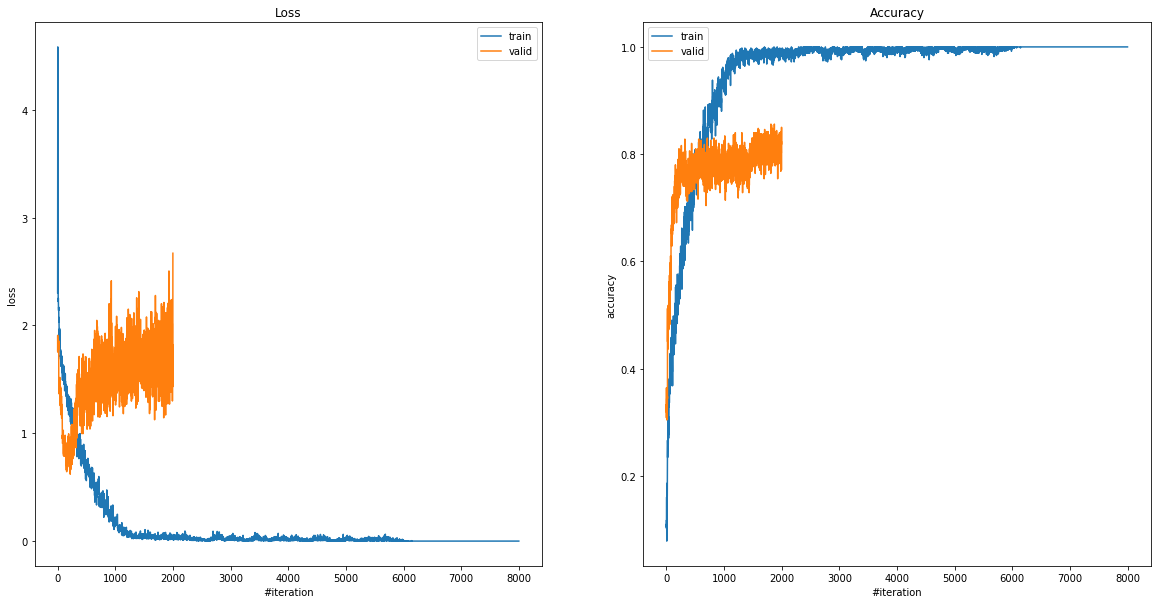

Epoch 100 of 100 time: 24.471s
  training loss (in-iteration): 	0.000004
  validation loss (in-iteration): 	1.759861
  train accuracy: 			100.00 %
  validation accuracy: 			80.99 %
Final results:
  test accuracy:		80.91 %
Achievement unlocked: 110lvl Warlock!


In [21]:
model = nn.Sequential(nn.Conv2d(3, 64, (7, 7), padding=(3, 3)),
                      nn.BatchNorm2d(64),
                      nn.ReLU(),
                      nn.Conv2d(64, 128, (5, 5), padding=(2, 2)),
                      nn.BatchNorm2d(128),
                      nn.ReLU(),
                      nn.MaxPool2d((2, 2), stride=2),
                      nn.Conv2d(128, 128, (3, 3), padding=(1, 1)),
                      nn.BatchNorm2d(128),
                      nn.ReLU(),
                      nn.Conv2d(128, 128, (3, 3), padding=(1, 1)),
                      nn.BatchNorm2d(128),
                      nn.ReLU(),
                      nn.Conv2d(128, 128, (3, 3), padding=(1, 1)),
                      nn.BatchNorm2d(128),
                      nn.ReLU(),
                      nn.MaxPool2d((2, 2), stride=2),
                      Flatten(),
                      nn.Linear(8192, 4000),
                      nn.ReLU(),
                      nn.Linear(4000, 1000),
                      nn.ReLU(),
                      nn.Linear(1000, 10)).cuda()
train(model, num_epochs=100, batch_size=500, optimizer_type=torch.optim.Adam)
evaluate(model)

```

```

```

```

```

```


# Report

All creative approaches are highly welcome, but at the very least it would be great to mention
* the idea;
* brief history of tweaks and improvements;
* what is the final architecture and why?
* what is the training method and, again, why?
* Any regularizations and other techniques applied and their effects;


There is no need to write strict mathematical proofs (unless you want to).
 * "I tried this, this and this, and the second one turned out to be better. And i just didn't like the name of that one" - OK, but can be better
 * "I have analyzed these and these articles|sources|blog posts, tried this and that to adapt them to my problem and the conclusions are such and such" - the ideal one
 * "I took that code that demo without understanding it, but i'll never confess that and instead i'll make up some pseudoscientific explaination" - __not__ __ok__

### Hi, my name is `Anastasia Torunova`, and here's my story

A long ago in a galaxy far far away, when it was still more than an hour before deadline, i got an idea:

##### I gonna build a simple "test" neural network, that has only three convolutional layers, interchanged with non-linearities. 

Architecture for this net was chosen more or less at random.
( Well, I still needed make shapes match layer requirements and convolutional kernels need to be of reasonable size.)

Architecture for the first net:

```
* conv: 7 * 7 kernel, 64 filters, stride=3, no padding
* ReLU
* conv: 5 * 5 kernel, 128 filters, stride=2, no padding
* ReLU
* conv 3 * 3 kernel, 128 filters, stride=2, no padding
* ReLU
* Flatten
* Linear 128 -> 10
```
After training for 50 epochs with Adam (default params) and batch_size=500 I got the following results:

* train accuracy: 96.10 %
* validation accuracy: 61.38 %
* test accuracy: 60.88 %

The training graph can be found above.
I decided to add batch normalisation after each convolution to improve convergence.

So, the next architecture was:


```
* conv: 7 * 7 kernel, 64 filters, stride=3, no padding
* batch_norm
* ReLU
* conv: 5 * 5 kernel, 128 filters, stride=2, no padding
* batch_norm
* ReLU
* conv 3 * 3 kernel, 128 filters, stride=2, no padding
* batch_norm
* ReLU
* Flatten
* Linear 128 -> 10
```

After training for 50 epochs with Adam (default params) and batch_size=500 I got the following results:

* train accuracy: 100.00 %
* validation accuracy: 64.55 %
* test accuracy: 64.52 %

The training graph can be found above.
Convergence rate improved, but accuracy was still pretty low.

So, I tried to find guidelines on how to build convolutional architectures and found [these CS231n lecture notes](http://cs231n.github.io/convolutional-networks/).
One of the points that authors made was that it is useful to separate filter size reduction and convolution using pooling layers and zero-padding and strides=1 so that filter size does not change after convolution.
So, I set out to incorporate these ideas into my new experiment.

Architecture was as follows:

```
* conv: 7 * 7 kernel, 64 filters, stride=1, padding 3 * 3
* batch_norm
* ReLU
* conv: 5 * 5 kernel, 128 filters, stride=1, padding 2 * 2
* batch_norm
* ReLU
* max_pooling 2*2 with stride=2
* conv 3 * 3 kernel, 128 filters, stride=1, no padding
* batch_norm
* ReLU
* conv 3 * 3 kernel, 128 filters, stride=1, no padding
* batch_norm
* ReLU
* max_pooling 2*2 with stride=2
* Flatten
* Linear 4608 -> 10
```
After training for 50 epochs with Adam (default params) and batch_size=500 I got the following results:

* train accuracy: 100.00 %
* validation accuracy: 82.29 %
* test accuracy: 81.77 %

The training graph can be found above.

Hoorray! I got over 80% accuracy on test! But that didn't stop me.

I tried to use Dropout in my next experiment, hoping that it will improve accuracy of my net.

Architecture:

```
* conv: 7 * 7 kernel, 64 filters, stride=1, padding 3 * 3
* batch_norm
* ReLU
* conv: 5 * 5 kernel, 128 filters, stride=1, padding 2 * 2
* batch_norm
* ReLU
* max_pooling 2*2 with stride=2
* conv 3 * 3 kernel, 128 filters, stride=1, no padding
* batch_norm
* ReLU
* conv 3 * 3 kernel, 128 filters, stride=1, no padding
* batch_norm
* ReLU
* max_pooling 2*2 with stride=2
* Flatten
* Linear 4608 -> 1000
* ReLU
* dropout with p=0.5
* Linear 1000 -> 10
```

Aaand it didn't work out as planned...

After training for 50 epochs with Adam (default params) and batch_size=500 I got the following results:

* train accuracy: 98.92 %
* validation accuracy: 80.71 %
* test accuracy: 79.75 %

The training graph can be found above.

So, with dropout accuracy not only didn't improve, but even got lower a little bit.

In my next experiment I tried to add more small convolutions, because it increases receptive field of a network. And used strides=1 whenever it was possible.

So, my last architecture was:

```
* conv: 7 * 7 kernel, 64 filters, stride=1, padding 3 * 3
* batch_norm
* ReLU
* conv: 5 * 5 kernel, 128 filters, stride=1, padding 2 * 2
* batch_norm
* ReLU
* max_pooling 2*2 with stride=2
* conv 3 * 3 kernel, 128 filters, stride=1, padding 1 * 1
* batch_norm
* ReLU
* conv 3 * 3 kernel, 128 filters, stride=1, padding 1 * 1
* batch_norm
* ReLU
* conv 3 * 3 kernel, 128 filters, stride=1, padding 1 * 1
* batch_norm
* ReLU
* max_pooling 2*2 with stride=2
* Flatten
* Linear 8192 -> 4000
* ReLU
* Linear 4000 -> 1000
* ReLU
* Linear 1000 -> 10
```

After training for 50 epochs with Adam (default params) and batch_size=500 I got the following results:

* train accuracy: 100.00 %
* validation accuracy: 80.99 %
* test accuracy: 80.91 %

The training graph can be found above.

So, nothing really changed since my third architecture.

##### Final architecture

Final architecture is the third one described.

That, having wasted 2 days of my life training, got

* accuracy on training: 100.0 %
* accuracy on validation: 82.29 %
* accuracy on test: 81.77 %


[an optional afterword and mortal curses on assignment authors]